<a href="https://colab.research.google.com/github/kakanasci/House-Prices-Project/blob/main/HousePricesProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Completo de Data Science: EDA, Engenharia de Features e Modelagem Preditiva (House Prices Kaggle)

In [27]:
#Importando bibliotecas

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

## CONFIGURAÇÃO DE VISUALIZAÇÃO

In [28]:
#Aplicar um tema limpo e profissional aos gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

## PREPARAÇÃO INICIAL DOS DADOS

In [29]:
# Carregar meus datasets de treino e teste
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [30]:
# Preciso guardar o ID do dataset de teste separadamente. Ele será necessário
# no final para gerar o arquivo de submissão do Kaggle.
test_ID = test['Id']

## TRATAMENTO DA VARIÁVEL ALVO (SalePrice)

In [31]:
# Isto normaliza a distribuição do preço e ajuda o modelo a focar em erros percentuais.
y_train = np.log1p(train['SalePrice'])

In [32]:
# Removendo as colunas 'Id' e 'SalePrice' da base de treino, pois não são features.
train = train.drop(['Id', 'SalePrice'], axis=1)

# Removendo 'Id' do dataset de teste.
test = test.drop('Id', axis=1)

## COMBINAÇÃO DE BASES

In [33]:
# Vou concatenar as bases de treino e teste. O objetivo é garantir que qualquer
# limpeza, imputação de dados faltantes ou engenharia de features que eu fizer
# seja aplicada de forma idêntica e uniforme aos dois conjuntos.
all_data = pd.concat((train, test)).reset_index(drop=True)

print(f"Bases combinadas com sucesso. Novo shape: {all_data.shape}")

Bases combinadas com sucesso. Novo shape: (2919, 79)


## VISUALIZAÇÃO DE DADOS FALTANTES

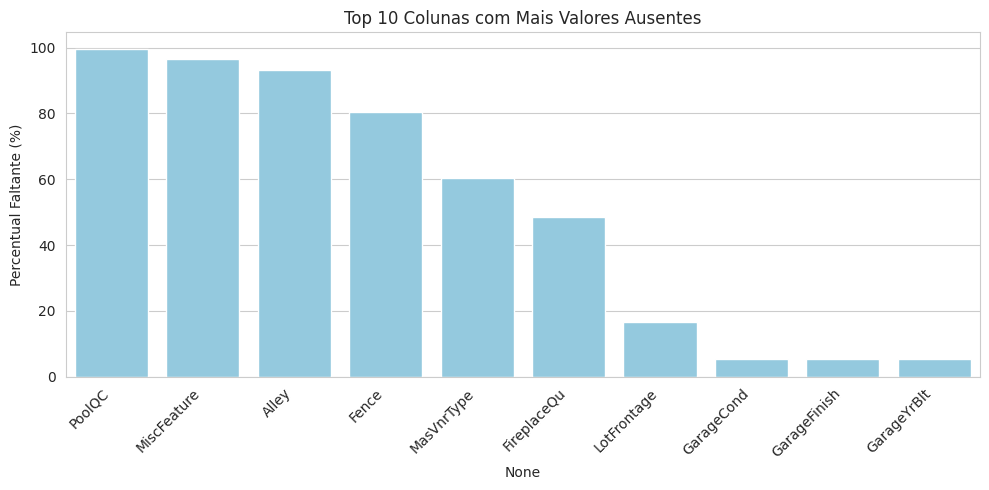

In [34]:
# Calculamos o percentual de dados faltantes
percent_missing = (all_data.isnull().sum() / all_data.isnull().count() * 100).sort_values(ascending=False)
# Filtramos apenas as colunas com mais de 1% de dados faltando e mostramos as 10 principais
missing_data = percent_missing[percent_missing > 1].head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=missing_data.index, y=missing_data.values, color='skyblue')
# Rotação para rótulos longos, crucial para um gráfico limpo
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Colunas com Mais Valores Ausentes')
plt.ylabel('Percentual Faltante (%)')
plt.tight_layout()
plt.show()

## Limpeza Lógica de Dados e Engenharia de Recursos

In [35]:
# Criei uma lista de colunas onde a ausência de valor ('NaN') indica a AUSÊNCIA do recurso.
# Para o modelo, é melhor que isso seja uma categoria 'None' do que um valor nulo.
cols_com_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                 'BsmtFinType2', 'MasVnrType', 'MSZoning', 'Utilities',
                 'Functional', 'KitchenQual', 'SaleType', 'Exterior1st',
                 'Exterior2nd', 'Electrical']

for col in cols_com_none:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna('None')

In [36]:
# Para as colunas de área ou contagem, se o recurso for ausente, a área/contagem é zero.
# Por exemplo, se não há garagem, a 'GarageArea' deve ser 0.
cols_com_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
                 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
                 'BsmtHalfBath', 'MasVnrArea']

for col in cols_com_zero:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

In [37]:
# O tamanho da fachada do lote ('LotFrontage') varia muito por localização.
# Usar a média geral seria ruim. Decidi preencher os valores ausentes com a MEDIANA
# específica do 'Neighborhood' (Bairro), o que é muito mais preciso.
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

In [38]:
# Preenchendo com a Mediana por bairro
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

## Engenharia de Recursos Essenciais

In [39]:
# Área Total da Casa ('TotalSF')
# Criei a feature 'TotalSF' porque a área total (subsolo + 1º + 2º andar) é o preditor
# mais importante e uma combinação mais poderosa do que as áreas separadas.
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [40]:
# Idade da Casa ('Age')
# Calculei a idade da casa, subtraindo o ano de construção do ano da venda.
# A idade é muitas vezes mais relevante que os anos absolutos.
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']

In [41]:
# Transformando Numéricas Ordinais em Categóricas
# Variáveis como 'OverallQual' (Qualidade Geral) são ratings numéricos,
# mas para o modelo de árvore, tratá-las como categorias separadas (strings)
# permite que ele capture melhor a relação não-linear com o preço.
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['OverallQual'] = all_data['OverallQual'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

## Codificação de Variáveis e Divisão Final

In [42]:
# Aplicando One-Hot Encoding em todas as variáveis categóricas.
# Isso transforma as strings em colunas binárias (0 ou 1) que o modelo pode processar.
all_data = pd.get_dummies(all_data)

# Re-dividir os dados de volta em Treino (com SalePrice) e Teste (para prever).
# Uso o comprimento (len) do 'y_train' original como ponto de corte.
X_train = all_data[:len(y_train)]
X_test = all_data[len(y_train):]

print(f"Pré-processamento concluído. Dataset de treino final shape: {X_train.shape}")

Pré-processamento concluído. Dataset de treino final shape: (1460, 355)


## Modelagem com XGBoost e Previsão

In [43]:
# Escolhi o XGBoost por ser um algoritmo de Gradient Boosting que é excelente
# para dados tabulares e alcança alta performance.
xgb_reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    objective='reg:squarederror'
)

In [44]:
# Treinando o modelo com os dados pré-processados
print("\nTreinando o modelo XGBoost...")
xgb_reg.fit(X_train, y_train)


Treinando o modelo XGBoost...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

## VALIDAÇÃO CRUZADA (CV)


In [45]:
def rmse_cv(model, X, y):
    # Uso 5-Fold para uma avaliação robusta
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(X.values)
    # Calculando o RMSE na escala logarítmica (Métrica principal)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return(rmse)

score = rmse_cv(xgb_reg, X_train, y_train)

In [46]:
print(f"\n-- Avaliação de Estabilidade (5-Fold Cross-Validation) --")
print(f"Média do RMSE (log): {score.mean():.4f}")
print(f"Desvio Padrão: {score.std():.4f} (Desvio baixo confirma modelo estável)")


-- Avaliação de Estabilidade (5-Fold Cross-Validation) --
Média do RMSE (log): 0.1226
Desvio Padrão: 0.0112 (Desvio baixo confirma modelo estável)


## IMPORTÂNCIA DE FEATURES (Interpreta o Modelo)

In [47]:
# Extraindo a importância das features e organizo
importances = pd.Series(xgb_reg.feature_importances_, index=X_train.columns)
top_10_features = importances.nlargest(10).sort_values()

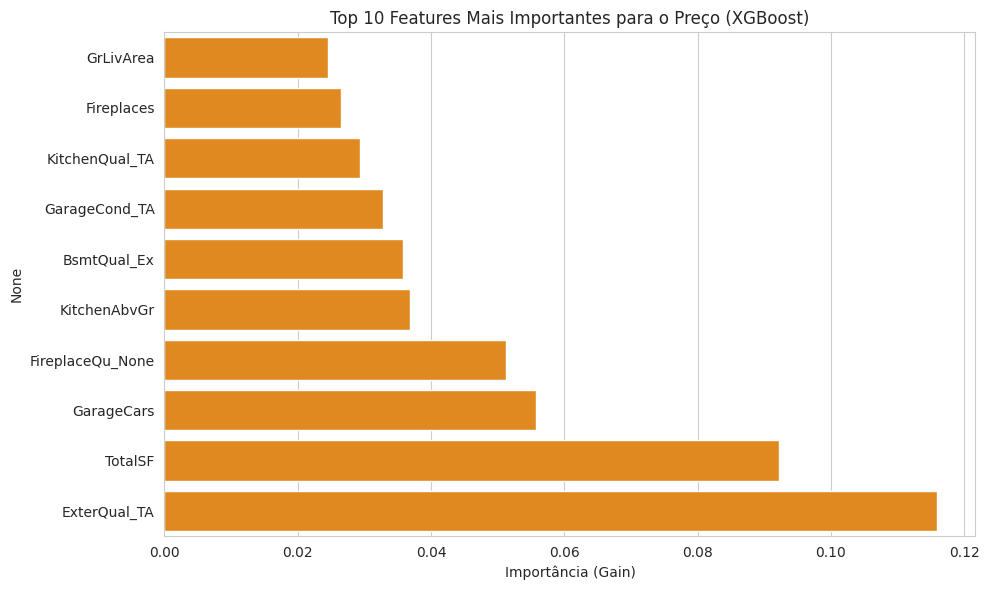

In [48]:
plt.figure(figsize=(10, 6))
# Gráfico de barras horizontal
sns.barplot(x=top_10_features.values, y=top_10_features.index, color='darkorange')
plt.title('Top 10 Features Mais Importantes para o Preço (XGBoost)')
plt.xlabel('Importância (Gain)')
plt.tight_layout()
plt.show()

## PREVISÃO E EXPORTAÇÃO

In [49]:
# Fazendo a previsão no conjunto de teste. O resultado ainda está na escala logarítmica.
predictions_log = xgb_reg.predict(X_test)

In [50]:
# Revertendo a transformação logarítmica para obter os preços reais.
# np.expm1 é a operação inversa de np.log1p.
final_predictions = np.expm1(predictions_log)

In [51]:
# Criando o DataFrame de submissão no formato exigido pelo Kaggle ('Id' e 'SalePrice').
submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': final_predictions
})

In [52]:
# Exportando para o arquivo .csv
submission.to_csv('House_Prices_Resultado.csv', index=False)

print("Arquivo de submissão criado:")
print("house_prices_Resultado.csv")


Arquivo de submissão criado:
house_prices_Resultado.csv
